<a href="https://colab.research.google.com/github/yohan-th/ft_sommelier/blob/master/ft_sommelier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import random
import math

# **V.1  Exploring the green reds**

Wine Quality Data Set of "Vinho Verde" red wine.

I didn't taste it, but we will trust expert's judgment.

https://archive.ics.uci.edu/ml/datasets/wine+quality

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 

In [8]:
data_csv = 'https://raw.githubusercontent.com/yohan-th/ft_sommelier/master/winequality-red.csv'
wine_data = pd.read_csv(data_csv, delimiter=';')#, nrows=5)
wine_data.head()

fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]

In [5]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
  df = pd.read_csv(wine_data, delimiter=';')#, usecols=[0, 1, 11], nrows=100)
  n_rows, n_colmn = df.shape
  
  fig, ax = plt.subplots(n_colmn, n_colmn, figsize=(40, 40))
  for axes in ax.flat:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
  plt.subplots_adjust(wspace=0.0, hspace=0.0)

  for i in range(n_colmn):
    for j in range(n_colmn):
      if i == j:
        ax[i, j].text(0.5, 0.5, df.columns[i], ha='center', size='xx-large', weight='bold')
      else:
        color = ['green' if k >= good_threshold else 'red' for k in df['quality']]
        size = [20 if k >= good_threshold else 20 if k <= bad_threshold else 0 for k in df['quality']]
        ax[i,j].scatter(df[df.columns[i]], df[df.columns[j]], alpha=0.30, s=size, c=color)

  if save_plot == True:
    plt.savefig('./redwinde_plot.png')

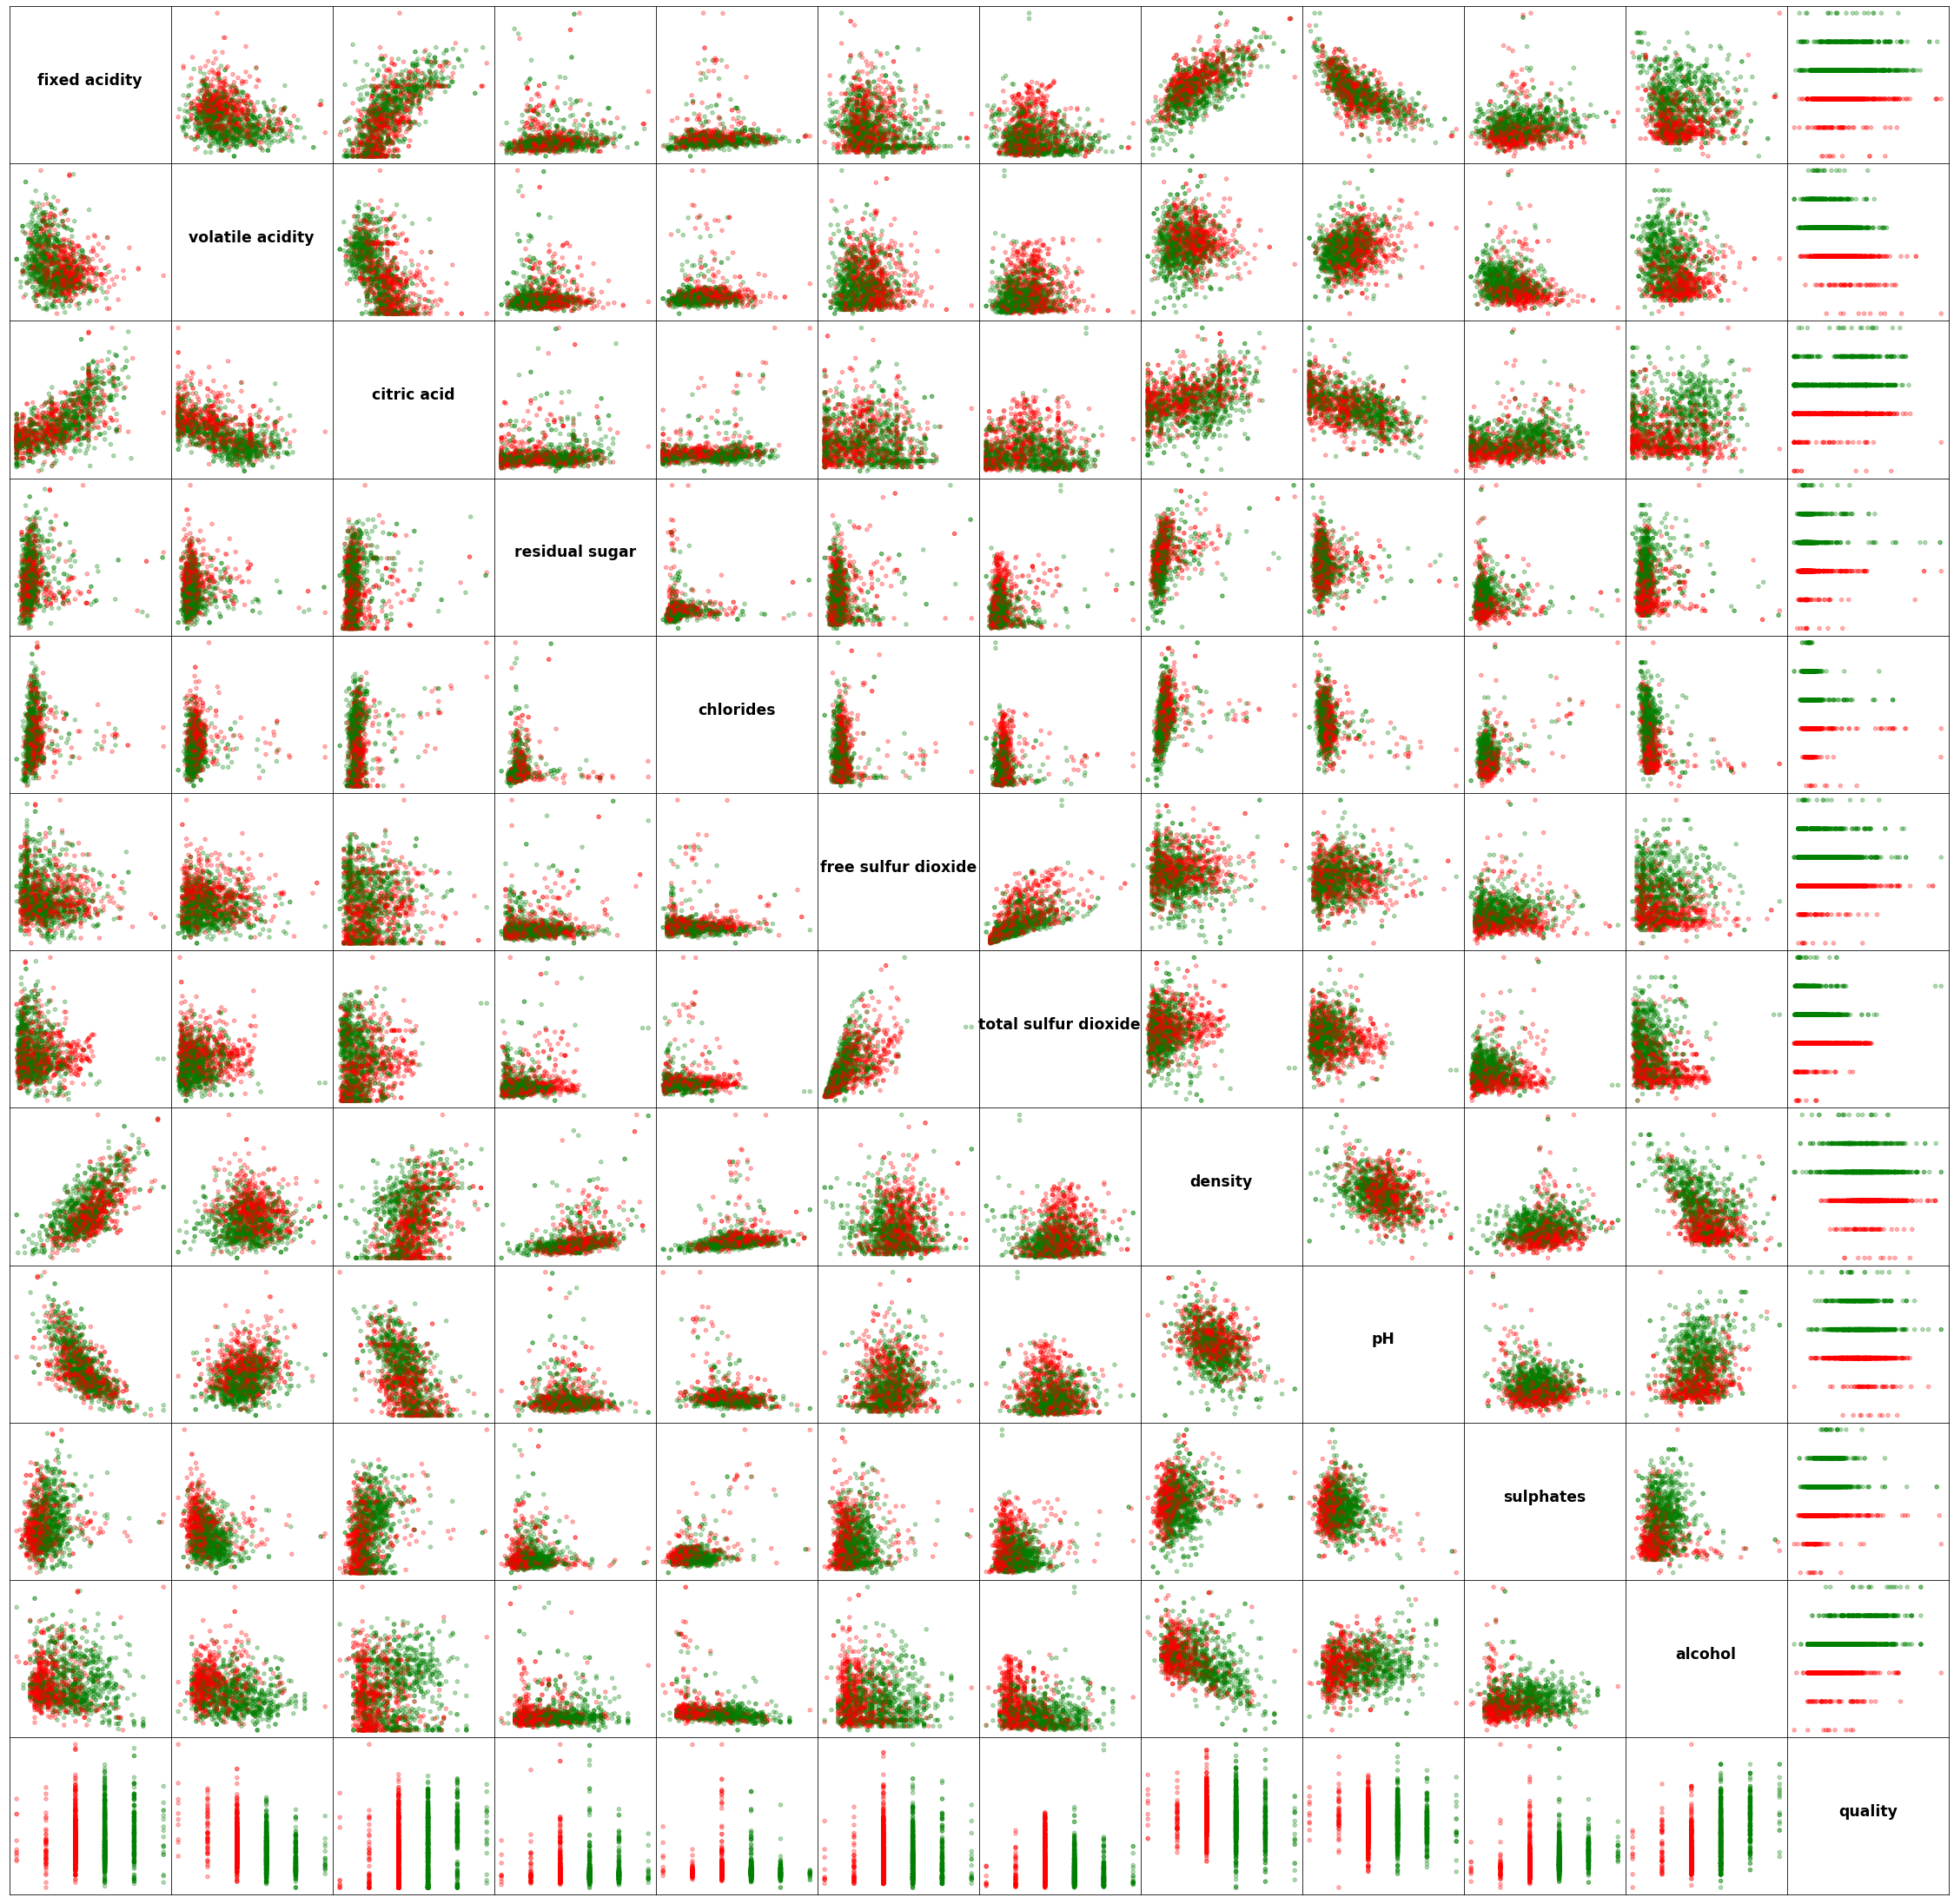

In [9]:
plot_scatter_matrix(data_csv, 6, 5, False)

The graphic shows the quality of wine (green=good & red=bad) in relation between 2 wine's attributes. **Most of plots don't show a distinct difference** between good and bad wine except attribute Sulphates and Alcohol where red and green dot seems to be separate.

We conclude attributes **sulphates** and **alcohol** is a good reference to judge if wine is good or not.


---




# **V.2  Learning to perceptron**

We will classify the wines as “good” or “bad” based on only chemical attributes with **perceptron algorithm**.
As concluded in V1 we choose **sulphates and alcohol attributes**.

In [11]:
wine_data = pd.read_csv(data_csv, delimiter=';')
wine_data = wine_data.assign(drunkable=pd.Series(wine_data['quality'] >= 6))
slct_data = wine_data[['pH', 'alcohol', 'quality', 'drunkable']]
slct_data = slct_data[(slct_data.quality >= 8) | (slct_data.quality <= 3)].reset_index()
slct_data['drunkable'] = slct_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our very good wines (quality >= 8) and very bad (quality <= 3)\n\n{slct_data}")

First a quick look of our very good wines (quality >= 8) and very bad (quality <= 3)

    index    pH  alcohol  quality  drunkable
0     267  3.35    12.80        8          1
1     278  3.23    12.60        8          1
2     390  3.56    12.90        8          1
3     440  2.88     9.80        8          1
4     455  3.22    13.40        8          1
5     459  3.25     9.00        3          0
6     481  3.15    11.70        8          1
7     495  3.15    11.00        8          1
8     498  3.15    11.00        8          1
9     517  3.16     8.40        3          0
10    588  3.72    14.00        8          1
11    690  3.63    10.70        3          0
12    828  3.46    12.70        8          1
13    832  3.38     9.90        3          0
14    899  3.48    11.00        3          0
15   1061  3.21    12.50        8          1
16   1090  2.98    11.80        8          1
17   1120  3.20    13.10        8          1
18   1202  3.35    11.70        8          1
19   1269  3.5

## [**PERCEPTRON**](https://www.rootandadmin.com/index.php/2019/06/03/the-perceptron-with-python/comment-page-1/)

1.   PRE-ACTIVATION FUNCTION

In [12]:
def pre_activation(features:list, weights:list, bias:int):
    # somme pondérées
    weighted_sum = 0
    
    for (feature, weight) in zip(features, weights):
        weighted_sum += feature * weight
    weighted_sum += bias
    
    return weighted_sum

2. ACTIVATION FUNCTION

In [13]:
# heaviside step activation function
def activation_function(value:int):
    # le seuil
    threshold = 0
    
    # etat du neurone : sortie y
    isActivated = bool
    
    # etat du neurone
    if value >= threshold:
        isActivated = True
    else:
        isActivated = False
        
    return int(isActivated) # 0/1

3. PERCEPTRON ALGORITHME

In [14]:
def training(lr:int, dataset:list, targets:list, max_epoch:int):
    # initialisations des poids synaptiques (parametres) random
    bias = random.random()
    weights = [random.random()] * len(dataset[0])
 
    # ITERATION SUR LES DONNEES
    convergence = False
    epoch = 0
    ret = []
    
    while not convergence:
        predictions = []
        for index, features in enumerate(dataset):
            pre_act = pre_activation(features=features, weights=weights, bias=bias)
            prediction = activation_function(pre_act)
            
            target = targets[index]
            predictions.append(prediction)
            
            # COST EVALUATION
            error = lr * (target - prediction)
            bias += error

            # Calculate new weight
            for i in range(len(weights)):
              weights[i] += error * features[i]
        
        nb_error = 0
        for index, pred in enumerate(predictions):
            if pred != targets[index]:
                nb_error += 1

        #mean_error = mean_error / len(predictions)

        # TEST DE CONVERGENCE
        if predictions == targets:
            convergence = True
            print("CONVERGENCE ! No error left")
        elif epoch == max_epoch:
            print(f"Max epoch reached : {epoch} epochs")
            convergence = True
        #print(f"ITERATION : {epoch} Error : {nb_error}")
        
        ret.append((epoch, nb_error, weights, bias))
        epoch += 1

    return ret

In [15]:
dataset = slct_data.loc[:, ['pH', 'alcohol']]
atr1 = list(dataset['pH'])
atr2 = list(dataset['alcohol'])
dataset = list(map(list, zip(atr1, atr2)))

labels = list(slct_data['drunkable'])

learning_rate = 0.01
train = training(learning_rate, dataset, labels, 14000)
print("[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]")
print(f"{train[0]}\n...\n{train[-1]}")

CONVERGENCE ! No error left
[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]
(0, 9, [-7.252619065785635, 1.7289809342090865], 0.14683701056006015)
...
(13131, 0, [-7.252619065785635, 1.7289809342090865], 6.136837010559974)


After few epochs our perceptron founds **correct values of weights and bias** for a boundary decision between good and bad wine with only pH and alcohol attributes.

## **Generate Plots**

To confirm our perceptron algorithme works we need to show plot of decision boundary with good and bad wine on each side

In [16]:
def draw_decision_boundary(axes, performance:list, data:list, att1:str, att2:str, epoch):
    x_min = data.loc[:, att1].min() - 0.2
    x_max = data.loc[:, att1].max() + 0.2
    y_min = data.loc[:, att2].min() - 0.2
    y_max = data.loc[:, att2].max() + 0.2
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))
    axes[1].set_ylabel(data.columns[0])
    axes[1].set_ylim([y_min, y_max])
    axes[1].set_xlabel(data.columns[1])
    axes[1].set_xlim([x_min, x_max])
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]
    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = [i * slope + intercept for i in x_coords]

    line = axes[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    axes[1].fill_between(x_coords, y_coords, y_min, color='#90EE90')
    axes[1].fill_between(x_coords, y_coords, y_max, color='#FA8072')
    
    return line

def draw_scatter(axes, data, att1:str, att2:str, good_thresh, bad_thresh):
    good_wines = data[(data['quality'] >= good_thresh)]
    bad_wines = data[(data['quality'] <= bad_thresh)]

    axes[1].scatter(good_wines.loc[:, att1], good_wines.loc[:, att2],
                    c=['g'], label='good wines (>= {} score)'.format(good_thresh))
    axes[1].scatter(bad_wines.loc[:, att1], bad_wines.loc[:, att2],
                    c=['r'], label='bad wines (<= {} score)'.format(bad_thresh))


def plot_performance(performance:list, data:list, att1:str, att2:str, good_thresh:int, bad_thresh:int, epoch=-1, save_plot=False):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

  #Error plot
  all_epoch = [elem[0] for elem in performance]
  all_error = [elem[1] for elem in performance]
  ax[0].plot(all_epoch, all_error)
  ax[0].set_title('Errors as a function of epoch')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Errors')

  #Boundary decision plot
  if epoch == -1:
      epoch = len(performance) - 1
  line = draw_decision_boundary(ax, performance, data, att1, att2, epoch)
  draw_scatter(ax, data, att1, att2, good_thresh, bad_thresh)
  ax[1].legend(bbox_to_anchor=(1, 1))

  if save_plot == True:
    plt.savefig('./performance_plot.png')



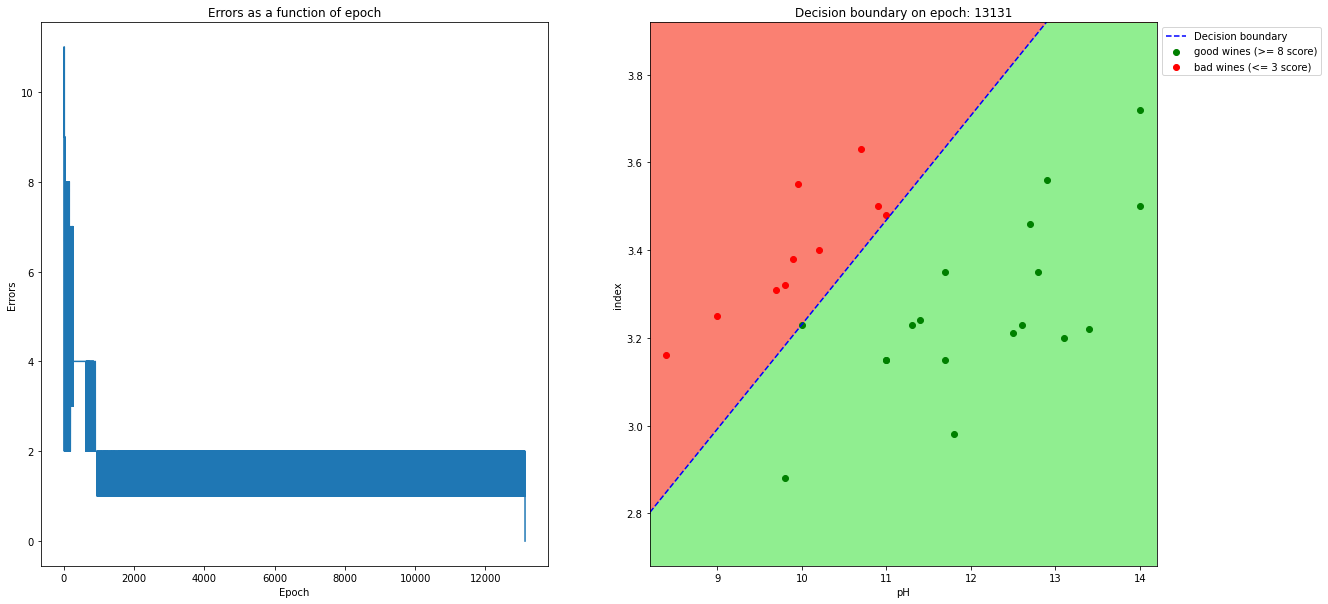

In [18]:
plot_performance(train, slct_data, 'alcohol', 'pH', 8, 3)

The Errors as function plot shows that our perceptron have **difficulties to find good weights and bias** with 2 last errors but at the end we have correct boundary decision between good and bad wine : green dots are on the green area and red dots are in red area.

To avoid this difficulties we will normalized pH and alcohol values to have common scale and optimize our further analysis. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

In [19]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

cpy_slct_data = slct_data

cpy_slct_data['pH'] = normalize_data(cpy_slct_data['pH'])
cpy_slct_data['alcohol'] = normalize_data(cpy_slct_data['alcohol'])

print(f"New data normalized\n\n{cpy_slct_data}\n")

atr1 = list(cpy_slct_data['pH'])
atr2 = list(cpy_slct_data['alcohol'])
dataset_normalized = list(map(list, zip(atr1, atr2)))

labels = list(slct_data['drunkable'])

New data normalized

    index        pH   alcohol  quality  drunkable
0     267  0.042942  0.262436        8          1
1     278 -0.099915  0.226722        8          1
2     390  0.292942  0.280293        8          1
3     440 -0.516582 -0.273278        8          1
4     455 -0.111820  0.369579        8          1
5     459 -0.076105 -0.416135        3          0
6     481 -0.195153  0.066008        8          1
7     495 -0.195153 -0.058992        8          1
8     498 -0.195153 -0.058992        8          1
9     517 -0.183248 -0.523278        3          0
10    588  0.483418  0.476722        8          1
11    690  0.376276 -0.112564        3          0
12    828  0.173895  0.244579        8          1
13    832  0.078656 -0.255421        3          0
14    899  0.197704 -0.058992        3          0
15   1061 -0.123724  0.208865        8          1
16   1090 -0.397534  0.083865        8          1
17   1120 -0.135629  0.316008        8          1
18   1202  0.042942  0.066008

In [20]:
learning_rate = 0.01
train_norm = training(learning_rate, dataset_normalized, labels, 100)
print("[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]")
print(f"{train_norm[0]}\n...\n{train_norm[-1]}")

CONVERGENCE ! No error left
[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]
(0, 10, [-0.1493975433329013, 0.23026763523852714], 0.07032944942079306)
...
(52, 0, [-0.1493975433329013, 0.23026763523852714], 0.04032944942079305)


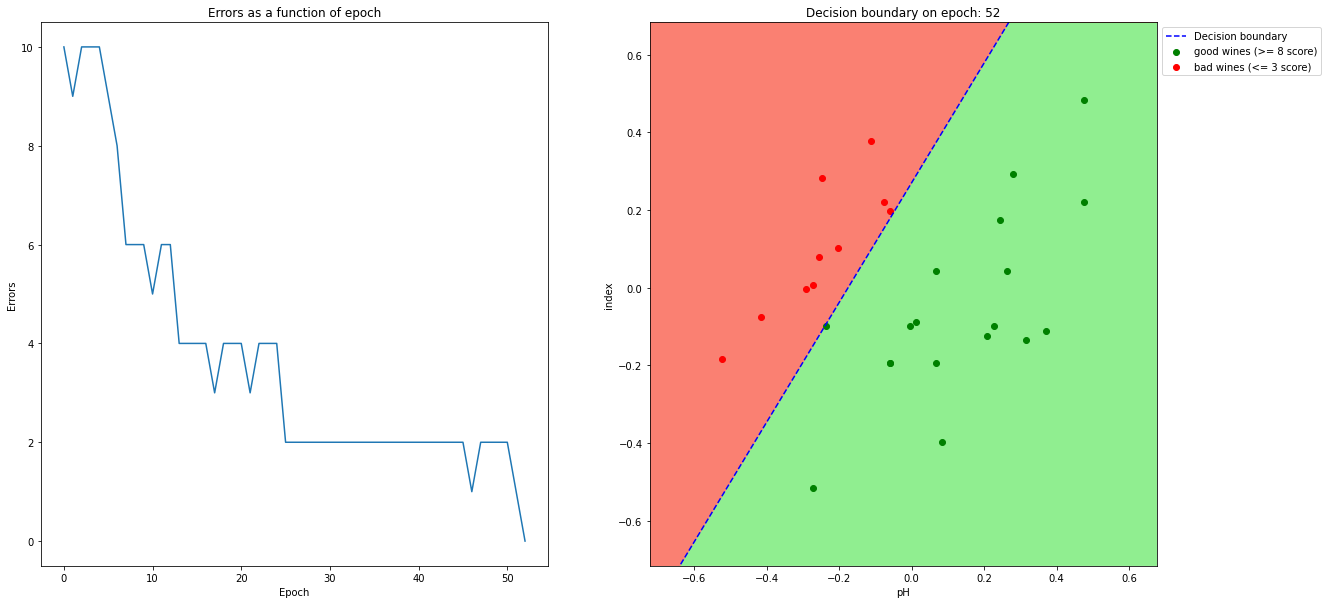

In [21]:
plot_performance(train_norm, cpy_slct_data, 'alcohol', 'pH', 8, 3)

# **V.3 Learning ADALINE (Adaptive Linear Neuron)**

We will classify the wines as “good” or “bad” **based on only chemical attributes** with ADALINE algorithm. As concluded in V1 we choose sulphates and alcohol attributes. This time we will distinguish **wines with a score of 4 and lower, and wines with a score of 7 and higher**.

In [23]:
wine_data = pd.read_csv(data_csv, delimiter=';')
wine_data = wine_data.assign(drunkable=pd.Series(wine_data['quality'] >= 6))
slct_data = wine_data[['pH', 'alcohol', 'quality', 'drunkable']]
slct_data = slct_data[(slct_data.quality >= 7) | (slct_data.quality <= 4)].reset_index(drop=True)
slct_data['drunkable'] = slct_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our good wines (quality >= 7) and bad (quality <= 4)\n\n{slct_data}")

First a quick look of our good wines (quality >= 7) and bad (quality <= 4)

       pH  alcohol  quality  drunkable
0    3.39    10.00        7          1
1    3.36     9.50        7          1
2    3.30    10.50        7          1
3    3.38     9.00        4          0
4    3.23     9.70        7          1
..    ...      ...      ...        ...
275  3.40    10.90        7          1
276  3.17    11.20        7          1
277  3.24    11.40        8          1
278  3.44    10.55        7          1
279  3.29    11.60        7          1

[280 rows x 4 columns]


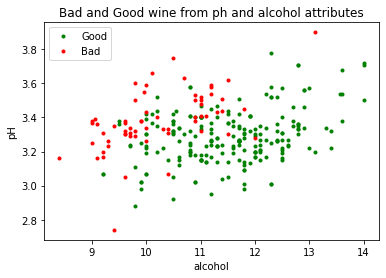

In [24]:
good_wines = slct_data[(slct_data['quality'] >= 7)]
bad_wines = slct_data[(slct_data['quality'] <= 4)]

# Plot
fig, ax = plt.subplots()
ax.plot(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'], c='g', marker='o', linestyle='', ms=3, label="Good")
ax.plot(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'], c='r', marker='o', linestyle='', ms=3, label="Bad")
ax.set_title('Bad and Good wine from ph and alcohol attributes')
ax.set_xlabel('alcohol')
ax.set_ylabel('pH')
ax.legend()


We see that good and bad wines are not clearly seperate. Single layer perceptrons are only capable of learning linearly so our perceptron can't distinguish good and bad wine with bondary decision. We need to use ADALINE algorithm.



## [**ADALINE**](https://www.bogotobogo.com/python/scikit-learn/Single-Layer-Neural-Network-Adaptive-Linear-Neuron.php)



In [25]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

def ft_dot(a, b):
    #somme pondéré
    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]
    
    return result

In [26]:
class Adaline(object):

    def __init__(self, lr):
        self.W = []
        self.bias = 0
        self.lr = lr
        self.performance = []

    def _pre_activation(self, X:list):
        # somme pondérée
        weighted_sum = 0
        for (xi, wi) in zip(X, self.W):
          weighted_sum += xi * wi
        return weighted_sum + self.bias

    def _activation(self, X:list):
        # non-linear activation function with 'Sigmoid or Logistic Activation Function'
        pre_activation = self._pre_activation(X)
        return 1 / (1 + math.exp(-1 * pre_activation))
    
    def _predict(self, X:list):
        threshold = 0.5 #-------
        return 1 if self._activation(X) > threshold else 0
    
    def _eval_epoch(self, X, y):
        nb_error = 0
        for xi, yi in zip(X, y):
            nb_error += int(self._predict(xi) != int(yi))
        return nb_error

    #Gradient_Descent/Widrow-Hoff/Delta_Rule learning ??
    def _train_epoch(self, X:list, y:list, epoch:int, mode:str):
        epoch_errors = []

        for xi, yi in zip(X, y):
            error = yi - self._activation(xi)
            epoch_errors.append(error)

            if mode == "stochastic":
              self.bias += self.lr * error #------
              self.W += self.lr * error * xi #------

        if mode == "batch":
          self.bias += self.lr * sum(epoch_errors) #------
          self.W += self.lr * ft_dot(X, epoch_errors) #------

        nb_error = self._eval_epoch(X, y)
        #print('Epoch {}, {} errors'.format(epoch, nb_error))

        self.performance.append((epoch, nb_error, self.W, self.bias))
        return nb_error

    def train(self, X:list, y:list, max_epochs:int, mode:str):

        # initialisations des poids synaptiques (parametres) random
        self.bias = random.random()
        self.W = [random.random()] * len(X[0])

        epoch = 0
        while True:
            epoch_nb_errors = self._train_epoch(X, y, epoch, mode)
            epoch += 1
            if epoch == max_epochs:
                break
            elif epoch_nb_errors == 0:
                break

        return self.performance

In [27]:
cpy_slct_data = slct_data

cpy_slct_data['pH'] = normalize_data(cpy_slct_data['pH'])
cpy_slct_data['alcohol'] = normalize_data(cpy_slct_data['alcohol'])

X = cpy_slct_data.loc[:, ['pH', 'alcohol']]
Y = cpy_slct_data['drunkable'].values

ada = Adaline(lr = 0.5)
train_adaline = ada.train(X.values, Y, 100, "stochastic")
print(train_adaline[0])
print("...")
print(train_adaline[-1])
print("Accuracy={0:.3f}".format((len(cpy_slct_data) - train_adaline[-1][1]) / len(cpy_slct_data)))

(0, 55, array([-9.24923185, 10.48077358]), 1.1514093684375815)
...
(99, 38, array([-9.24923185, 10.48077358]), 2.4095382443462907)
Accuracy=0.864


## Research good parameters

Now let's find the best :

*   learning rate
*   number of epochs
*   batch or stochastic learning

To get the faster and smallest number of classification errors with our ADALINE algorithm.

Accuracy=0.864


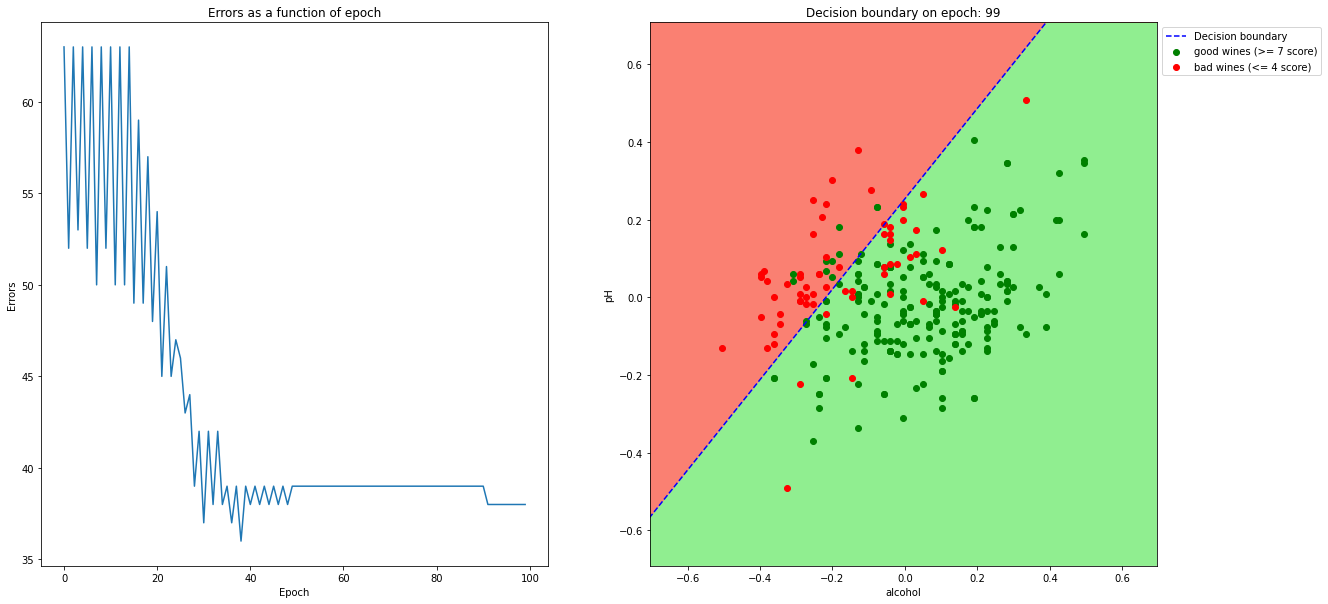

In [28]:
ada = Adaline(lr = 0.05)
train_adaline = ada.train(X.values, Y, 100, "batch")
plot_performance(train_adaline, cpy_slct_data, 'alcohol', 'pH', 7, 4)
print("Accuracy={0:.3f}".format((len(cpy_slct_data) - train_adaline[-1][1]) / len(cpy_slct_data)))

Accuracy=0.864


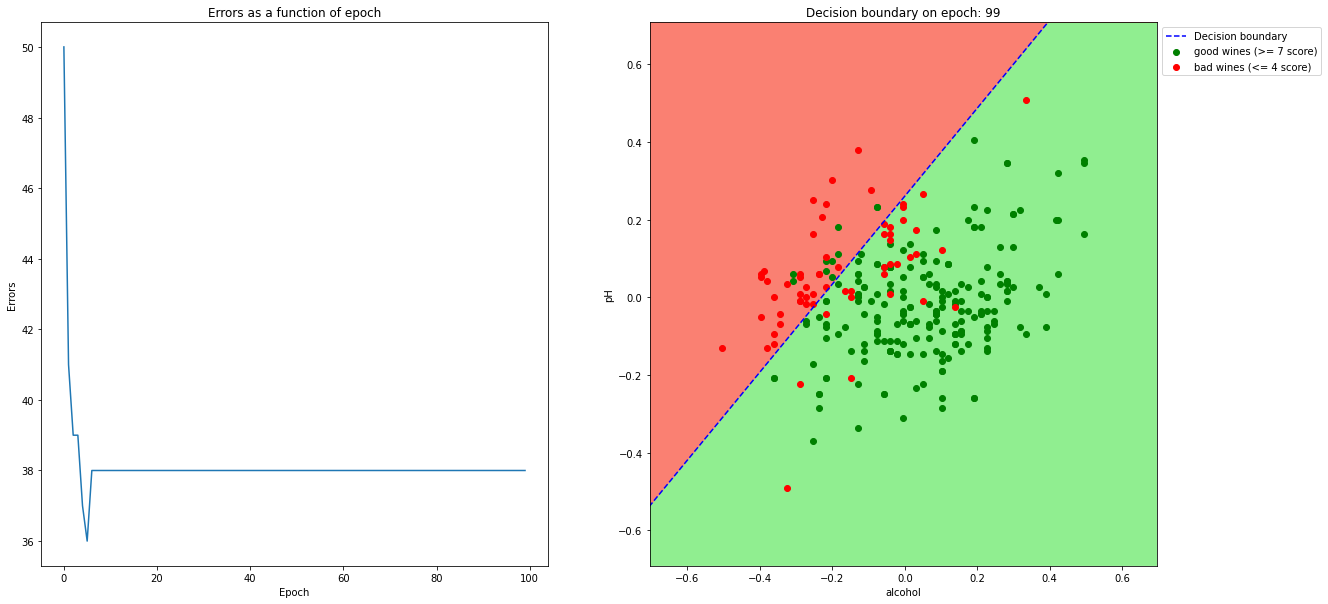

In [29]:
ada = Adaline(lr = 0.5)
train_adaline = ada.train(X.values, Y, 100, "stochastic")
plot_performance(train_adaline, cpy_slct_data, 'alcohol', 'pH', 7, 4)
print("Accuracy={0:.3f}".format((len(cpy_slct_data) - train_adaline[-1][1]) / len(cpy_slct_data)))

Accuracy=0.864


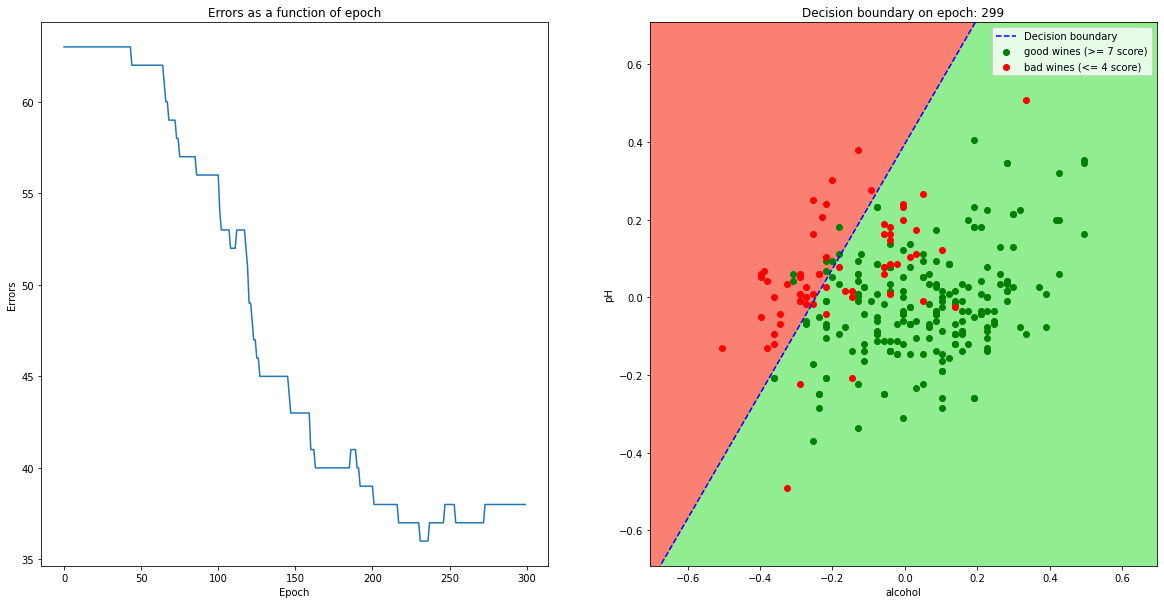

In [30]:
ada = Adaline(lr = 0.005)
train_adaline = ada.train(X.values, Y, 300, "batch")
plot_performance(train_adaline, cpy_slct_data, 'alcohol', 'pH', 7, 4)
print("Accuracy={0:.3f}".format((len(cpy_slct_data) - train_adaline[-1][1]) / len(cpy_slct_data)))

Accuracy=0.864


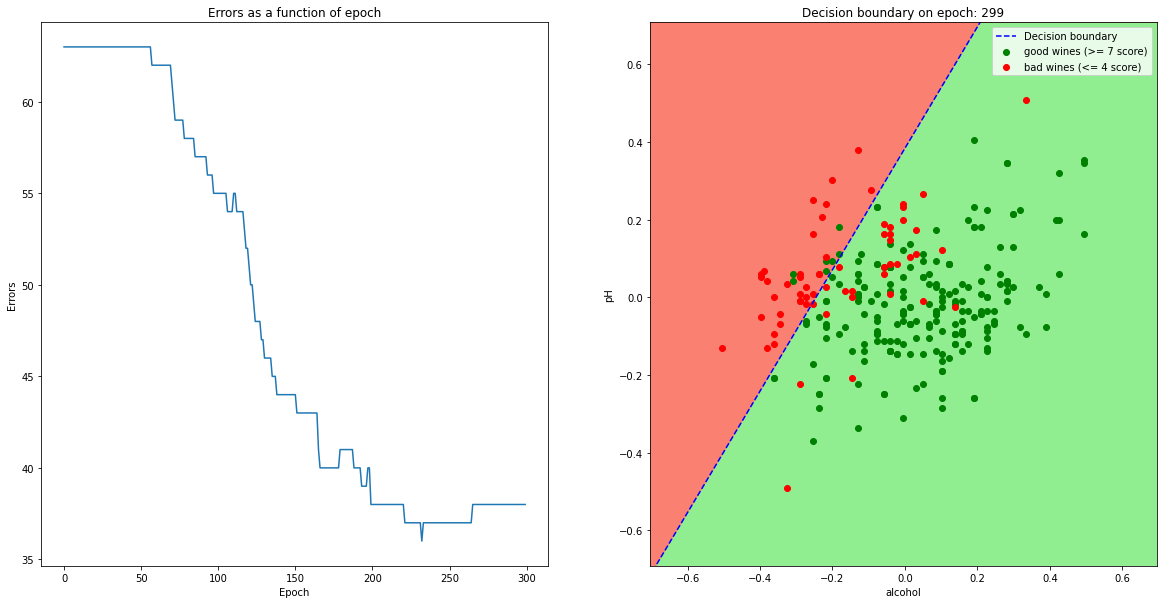

In [31]:
ada = Adaline(lr = 0.005)
train_adaline = ada.train(X.values, Y, 300, "stochastic")
plot_performance(train_adaline, cpy_slct_data, 'alcohol', 'pH', 7, 4)
print("Accuracy={0:.3f}".format((len(cpy_slct_data) - train_adaline[-1][1]) / len(cpy_slct_data)))

With a high learning rate (0.5) **stochastic is more efficient compare to batch learning**. With small learning rate (0.005) batch and stochastic learning are similaire.

# **V.4 CROSS-VALIDATION with ADALINE**

To avoid overfitting and be sure we calculate weights and bias in the good way we will use k-fold cross-validation.



First with Holdout Method we will shuffle data and cut our datast in k part with on each k fold :
*   training data
*   validation data



In [32]:
def ft_dataset_split(dataset:list, prctg:int):
  train_dataset = dataset.sample(frac=prctg/100)
  valid_dataset = dataset.drop(train_dataset.index).reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  #print(f"Train_dataset size = {len(train_dataset)}\nValid_dataset size = {len(valid_dataset)}")
  
  return (train_dataset, valid_dataset)

In [33]:
def k_fold_split(data, k, prctg_train_valid, shuffle=True):
    k_folds = []
    
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    
    nb_elem = int(len(data) / k)

    for i in range(k):
        prctg = nb_elem * 100 / len(data)
        k_fold, data = ft_dataset_split(data, prctg)
        train_set, valid_set = ft_dataset_split(k_fold, prctg_train_valid)
        k_folds.append((train_set, valid_set))
    
    if len(data) > 0:
        print("inexacte size")
        extra_train, valid = k_folds[0]
        k_folds[0] = extra_train.append(data).reset_index(drop=True), valid

    return k_folds

In [34]:
folds = k_fold_split(cpy_slct_data, 6, 60)
print("With 8 folds : :")
for train_set, valid_set in folds:
  print(f"({len(train_set)} features for train, {len(valid_set)} features for valid)")

inexacte size
With 8 folds : :
(32 features for train, 18 features for valid)
(28 features for train, 18 features for valid)
(28 features for train, 18 features for valid)
(28 features for train, 18 features for valid)
(28 features for train, 18 features for valid)
(28 features for train, 18 features for valid)


Then we will use k-cross-validation on each fold of our dataset



In [35]:
def k_cross_validation_ADALINE(folds, features, lr=0.5, nb_epochs=6, mode="stochastic"):
  sum_accuracy = 0

  for train_set, valid_set in folds:
    X_train = train_set.loc[:, features]
    Y_train = train_set['drunkable']

    ad = Adaline(lr)
    result = ad.train(X_train.values, Y_train.values, nb_epochs, mode)

    X_valid = valid_set.loc[:, features]
    Y_valid = valid_set['drunkable']
    nb_error = ad._eval_epoch(X_valid.values, Y_valid.values)
    acc = (len(X_valid) - nb_error) / len(X_valid)
    #print("Model accuracy = {0:.3f}".format(acc))
    sum_accuracy += acc

  print("Mean model accuracy = {0:.3f}".format(sum_accuracy / len(folds)))

In [37]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'])

Mean model accuracy = 0.778


## Research good parameters

We search for the best accuracy with lowest number of epoch playing with :


*   learning rate
*   stochastic or batch mode

We could also change :

*   number of k fold
*   percentage when split train and valid dataset

But our dataset is not big enough, only 180 features. After 10 000 features it begins to be interesting.



In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.9, 120)

Mean model accuracy = 0.889


In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.5, 90)

Mean model accuracy = 0.880


In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.1, 190)

Mean model accuracy = 0.880


In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.05, 380)

Mean model accuracy = 0.880


With stochastic mode high learning rate is interesting.

In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.9, 140, "batch")

Mean model accuracy = 0.787


In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.5, 40, "batch")

Mean model accuracy = 0.880


In [ ]:
k_cross_validation_ADALINE(folds, ['pH', 'alcohol'], 0.05, 1900, "batch")

Mean model accuracy = 0.889


With batch mode a low learning rate is interesting but cost a lot of epoch compare to stochastic

#  **V.5 adventures in the Nth dimension**

Let's try with more attributes and different values of wine quality

In [38]:
wine_data = pd.read_csv(data_csv, delimiter=';')
wine_data = wine_data.assign(drunkable=pd.Series(wine_data['quality'] >= 6))
mltp_slct_data = wine_data[['pH', 'alcohol', 'total sulfur dioxide', 'density', 'quality', 'drunkable']]
mltp_slct_data = mltp_slct_data[(mltp_slct_data.quality >= 6) | (mltp_slct_data.quality <= 5)].reset_index(drop=True)
mltp_slct_data['drunkable'] = mltp_slct_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our good wines (quality >= 6) and bad (quality <= 4)\n\n{mltp_slct_data}")

First a quick look of our good wines (quality >= 6) and bad (quality <= 4)

        pH  alcohol  total sulfur dioxide  density  quality  drunkable
0     3.51      9.4                  34.0  0.99780        5          0
1     3.20      9.8                  67.0  0.99680        5          0
2     3.26      9.8                  54.0  0.99700        5          0
3     3.16      9.8                  60.0  0.99800        6          1
4     3.51      9.4                  34.0  0.99780        5          0
...    ...      ...                   ...      ...      ...        ...
1594  3.45     10.5                  44.0  0.99490        5          0
1595  3.52     11.2                  51.0  0.99512        6          1
1596  3.42     11.0                  40.0  0.99574        6          1
1597  3.57     10.2                  44.0  0.99547        5          0
1598  3.39     11.0                  42.0  0.99549        6          1

[1599 rows x 6 columns]


In [39]:
mltp_slct_data['pH'] = normalize_data(mltp_slct_data['pH'])
mltp_slct_data['alcohol'] = normalize_data(mltp_slct_data['alcohol'])
mltp_slct_data['total sulfur dioxide'] = normalize_data(mltp_slct_data['total sulfur dioxide'])
mltp_slct_data['density'] = normalize_data(mltp_slct_data['density'])
print(f"First a quick look of our good wines (quality >= 6) and bad (quality <= 4)\n\n{mltp_slct_data}")

First a quick look of our good wines (quality >= 6) and bad (quality <= 4)

            pH   alcohol  total sulfur dioxide   density  quality  drunkable
0     0.156604 -0.157382             -0.044056  0.077336        5          0
1    -0.087491 -0.095844              0.072552  0.003915        5          0
2    -0.040247 -0.095844              0.026616  0.018599        5          0
3    -0.118987 -0.095844              0.047817  0.092021        6          1
4     0.156604 -0.157382             -0.044056  0.077336        5          0
...        ...       ...                   ...       ...      ...        ...
1594  0.109360  0.011849             -0.008720 -0.135586        5          0
1595  0.164478  0.119541              0.016015 -0.119433        6          1
1596  0.085738  0.088772             -0.022854 -0.073912        6          1
1597  0.203848 -0.034305             -0.008720 -0.093736        5          0
1598  0.062116  0.088772             -0.015787 -0.092267        6          1


In [40]:
mtltp_folds = k_fold_split(mltp_slct_data, 9, 70)
print("With 9 folds : :")
for train_set, valid_set in mtltp_folds:
  print(f"({len(train_set)} features for train, {len(valid_set)} features for valid)")

inexacte size
With 9 folds : :
(130 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)
(124 features for train, 53 features for valid)


In [41]:
k_cross_validation_ADALINE(mtltp_folds, ['pH', 'alcohol', 'total sulfur dioxide', 'density'], 0.005, 500)

Mean model accuracy = 0.686


After few tests we noticed : 

*   With more attribute we need less epochs to reach best possible accuracy
*   With low learning rate stochastic/batch are the same
*   With high learning rate stochastic need less epoch

# **V.6 Pan Galactic Gargle Blaster**

The Pan Galactic Gargle Blaster is an alcoholic beverage invented by ex-President of the Galaxy **Zaphod Beeblebrox**, considered by the Guide to be the **"Best Drink in Existence"**. Its effects are similar to **"having your brains smashed out by a slice of lemon wrapped round a large gold brick."**

In [43]:
pggb_data = pd.read_csv("https://raw.githubusercontent.com/yohan-th/ft_sommelier/master/Pan%20Galactic%20Gargle%20Blaster.csv", delimiter=';')
pggb_data = pggb_data.assign(drunkable=pd.Series(pggb_data['quality'] >= 5))
pggb_data['drunkable'] = pggb_data['drunkable'].map({True:1, False:0})
print(f"First a quick look of our good wines (quality >= 7) and bad (quality <= 4)\n\n{pggb_data}")

First a quick look of our good wines (quality >= 7) and bad (quality <= 4)

     wonderflonium  fallian marsh gas  quality  drunkable
0         4.151636           5.350607        2          0
1         3.403125           4.787343        2          0
2         5.036224           4.609847        2          0
3         4.483534           4.332340        9          1
4         4.215979           5.220295        2          0
..             ...                ...      ...        ...
995       4.427725           4.337821        6          1
996       3.804685           3.697738        3          0
997       4.572932           3.253231        2          0
998       4.099439           3.240547        1          0
999       4.106536           4.354760        6          1

[1000 rows x 4 columns]


<class 'pandas.core.frame.DataFrame'>


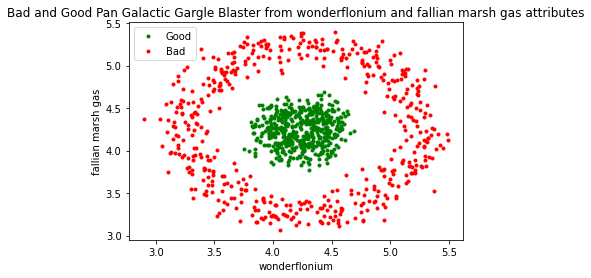

In [44]:
good_pggb = pggb_data[(pggb_data['quality'] >= 5)]
print(type(good_pggb))
bad_pggb = pggb_data[(pggb_data['quality'] <= 4)]

# Plot
fig, ax = plt.subplots()
ax.plot(good_pggb.loc[:, 'wonderflonium'], good_pggb.loc[:, 'fallian marsh gas'], c='g', marker='o', linestyle='', ms=3, label="Good")
ax.plot(bad_pggb.loc[:, 'wonderflonium'], bad_pggb.loc[:, 'fallian marsh gas'], c='r', marker='o', linestyle='', ms=3, label="Bad")
ax.set_title('Bad and Good Pan Galactic Gargle Blaster from wonderflonium and fallian marsh gas attributes')
ax.set_xlabel('wonderflonium')
ax.set_ylabel('fallian marsh gas')
ax.legend()


In **Cartesian Coordinates** our data is not linearly seperable so it's not possible to use our Perceptron or Adaline algorithme to draw boundary decision. If we [convert our data](https://www.mathsisfun.com/polar-cartesian-coordinates.html) to **Polar Coordinates** it will be possible.

In [45]:
pggb_data['wonderflonium'] = normalize_data(pggb_data['wonderflonium'])
pggb_data['fallian marsh gas'] = normalize_data(pggb_data['fallian marsh gas'])

x1 = pggb_data.loc[:, 'wonderflonium']
x2 = pggb_data.loc[:, 'fallian marsh gas']

pggb_data = pggb_data.assign(r=pd.Series(x1 ** 2 + x2 ** 2).pow(1./2))
pggb_data = pggb_data.assign(phi=pd.Series([math.atan2(x, y) for (x, y) in zip(x1, x2)]))

print(pggb_data)

     wonderflonium  fallian marsh gas  quality  drunkable         r       phi
0        -0.035156           0.475916        2          0  0.477213 -0.073737
1        -0.323510           0.233752        2          0  0.399123 -0.945096
2         0.305619           0.157442        2          0  0.343789  1.095098
3         0.092703           0.038133        9          1  0.100239  1.180546
4        -0.010369           0.419891        2          0  0.420019 -0.024690
..             ...                ...      ...        ...       ...       ...
995       0.071204           0.040490        6          1  0.081911  1.053750
996      -0.168815          -0.234701        3          0  0.289107 -2.518047
997       0.127142          -0.425808        2          0  0.444384  2.851429
998      -0.055265          -0.431261        1          0  0.434788 -3.014141
999      -0.052531           0.047772        6          1  0.071005 -0.832802

[1000 rows x 6 columns]


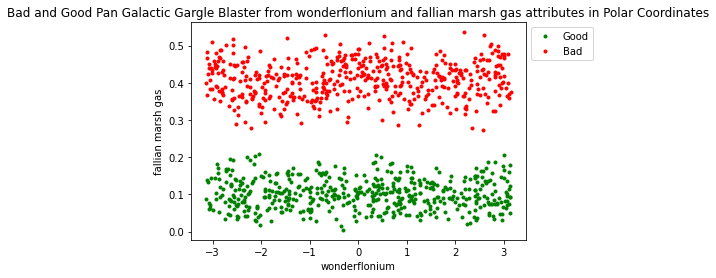

In [46]:
good_pggb = pggb_data[(pggb_data['quality'] >= 5)]
bad_pggb = pggb_data[(pggb_data['quality'] <= 4)]

# Plot
fig, ax = plt.subplots()
ax.plot(good_pggb.loc[:, 'phi'], good_pggb.loc[:, 'r'], c='g', marker='o', linestyle='', ms=3, label="Good")
ax.plot(bad_pggb.loc[:, 'phi'], bad_pggb.loc[:, 'r'], c='r', marker='o', linestyle='', ms=3, label="Bad")
ax.set_title('Bad and Good Pan Galactic Gargle Blaster from wonderflonium and fallian marsh gas attributes in Polar Coordinates')
ax.set_xlabel('wonderflonium')
ax.set_ylabel('fallian marsh gas')
ax.legend(bbox_to_anchor=(1, 1))

In [49]:
pggb_data['r'] = normalize_data(pggb_data['r'])
pggb_data['phi'] = normalize_data(pggb_data['phi'])

X = pggb_data.loc[:, ['r', 'phi']]
Y = pggb_data['drunkable'].values

ada = Adaline(lr = 0.05)
train_adaline = ada.train(X.values, Y, 10, "batch")
print("Accuracy={0:.3f}".format((len(pggb_data) - train_adaline[-1][1]) / len(pggb_data)))

Accuracy=1.000


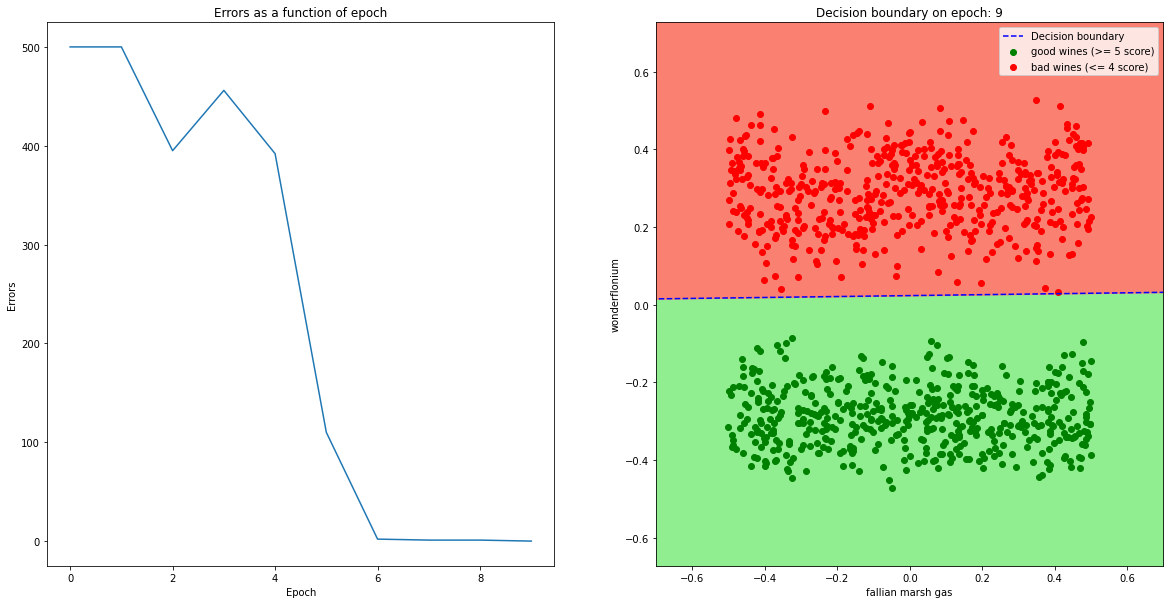

In [50]:
plot_performance(train_adaline, pggb_data, 'phi', 'r', 5, 4)